<h1> Lab Six: Convolutional Network Architectures </h1>

<h4> Adam Ashcraft, Maya Muralidhar, Nora Potenti, Michael Watts </h4>

<h1> 1.0 Preparation </h1>

<h2> 1.1 Business Understanding </h2>

This is a dataset of approximately 4,300 images of flowers. These images have been taken from Flickr, Google, and Yandax and are divided into five categories: dasies, dandelions, roses, sunflowers, and tulips. The images were collected by performing a data scrape of these image hosting services by the dataset creator Alexander Mamaev. The images are in standard definition quality and do not have a standardized size. According to the Kaggle page, the data was collected to answer the question, “What kind of flower is that?” The creator also includes a prediction task for the data on Kaggle, “You can use this dataset to recognize plants from the photo.” 

This tool would primary serve the completely flower illiterate. It provides a very basic stepping stone into the wide world of botany for those with no experience in the field. With an application like this, a user will be able to successfully differentiate between different types of flowers based on subtler nuances than simply factors like color. Ideally, this would prevent someone from buying sunflowers instead of tulips simply because they are the same color. 


Another plant photo identification tool already exists in the market, Plantsnap. According to the Plantsnap website, it boasts a 96% success rate. In order for our tool to be considered viable, it must have at least, if not greater than, a 96% success rate.  

<hr>
Kaggle dataset: https://www.kaggle.com/alxmamaev/flowers-recognition <br>
Plantsnap self reported success rate: https://plantsnap.com/faq/

<h2> 1.2 Evaluation Criteria </h2>

Before we determine our evaluation criteria, let’s take a moment to look at our data.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import glob
import pickle
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display
from sklearn.model_selection import train_test_split
import cv2
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from scipy.misc import imresize
from sklearn import metrics as mt
from keras.models import load_model

C:\Users\mayam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#use glob to get all file names in each folder
daisyFiles = glob.glob("flowers/daisy/*")
dandelionFiles = glob.glob("flowers/dandelion/*")
roseFiles = glob.glob("flowers/rose/*")
sunflowerFiles = glob.glob("flowers/sunflower/*")
tulipFiles = glob.glob("flowers/tulip/*")

daisies = []
dandelions = []
roses = []
sunflowers = []
tulips = []
#function to take image name, open image as numpy array and add to list
def addImageToArray(imageFileArray, imageArray):
    for file in imageFileArray:
        imageArray.append(np.asarray(Image.open(file)))
        
addImageToArray(daisyFiles,daisies)
addImageToArray(dandelionFiles,dandelions)
addImageToArray(roseFiles,roses)
addImageToArray(sunflowerFiles,sunflowers)
addImageToArray(tulipFiles,tulips)

In [3]:
def convertToGrayScale(RGBArray):
    return np.dot(RGBArray[...,:3], [0.3, 0.59, 0.11])
def convertAllImagesToGrey(ImageArray):
    for i in range (0, len(ImageArray)):
        ImageArray[i] = convertToGrayScale(ImageArray[i])
convertAllImagesToGrey(daisies)
convertAllImagesToGrey(dandelions)
convertAllImagesToGrey(roses)
convertAllImagesToGrey(sunflowers)
convertAllImagesToGrey(tulips)

([<matplotlib.patches.Wedge at 0x20a2eab0a58>,
 [Text(0.932655,0.583228,'Daisy'),
  Text(-0.337028,1.0471,'Dandelion'),
  Text(-1.09692,-0.08226,'Rose'),
  Text(-0.421044,-1.01623,'Sunflower'),
  Text(0.830539,-0.721253,'Tulip')],
 [Text(0.508721,0.318124,'17.8%'),
  Text(-0.183834,0.571144,'24.3%'),
  Text(-0.59832,-0.0448691,'18.1%'),
  Text(-0.22966,-0.554307,'17.0%'),
  Text(0.453021,-0.393411,'22.8%')])

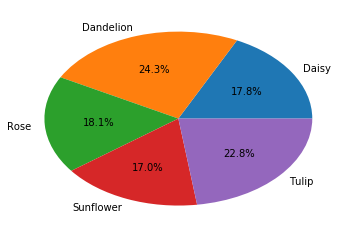

In [4]:
pieValues = [len(daisies), len(dandelions), len(roses), len(sunflowers), len(tulips)]
plt.pie(x=pieValues,labels=['Daisy', 'Dandelion', 'Rose', 'Sunflower','Tulip'], autopct='%1.1f%%')

A false negative and a false positive both represent the same idea here, an erroneous categorization of the flower for our user. Considering the fact, we are working with total flower novices, we will want to minimize both our false positive and false negatives rates as much as possible. We cannot assume our user is knowledgeable enough to detect them himself. We must also take into account the slight class imbalance we see in the above graphic. Dandelions and Tulips represent almost 50% of the classes in the data set. In order to focus on minimizing both the false positives and false negatives as well consider the class imbalance, we will use F1 score.


In [5]:
%%capture --no-display

croppedDaisies = [imresize(x,size=(330,500), interp='nearest') for x in daisies]    

croppedDandelions = [imresize(x,size=(330,500), interp='nearest') for x in dandelions]   

croppedRoses =[imresize(x,size=(330,500), interp='nearest') for x in roses]  

croppedSunflowers = [imresize(x,size=(330,500), interp='nearest') for x in sunflowers]    

croppedTulips = [imresize(x,size=(330,500), interp='nearest') for x in tulips] 

In [6]:
def flattenMatrix(arrayOfMatracies):
    flattenedArray = []
    for m in arrayOfMatracies:
        flattenedArray.append(m.flatten())
        
    return flattenedArray


<h2> 1.2 Data Division </h2>

For our data division, we will do a stratified shuffle train test split across our data then use a stratified shuffle split. The stratification will correct for the class imbalance of the data. The data is currently grouped into 5 groups, 1 per class. This is not an accurate reflection of how our model will be used. It is highly unlikely that the application will only ever see one kind of flower at a time, iteration after iteration. It will more than likely be exposed to a wide variety of flower with every use. In order to better model this, the data will be shuffled in order to split the groups of classes up and distribute them among the k-folds. The train-test split will give us a section of data never before seen by our model we can use to easily check its performance against. 



In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=1)
X = np.array(croppedDaisies + croppedTulips + croppedDandelions + croppedRoses + croppedSunflowers)
y = np.array(len(croppedDaisies)*[0] + len(croppedTulips)*[1] + len(croppedDandelions)*[2] + len(croppedRoses)*[3] + len(croppedSunflowers)*[4])
X_split, X_test, y_split, y_test = train_test_split(X, y, stratify = y, shuffle = True, random_state=42, test_size=0.2)

X_test_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_test]

X_test_resize = np.stack(X_test_resize,axis=0)
X_test_resize = flattenMatrix(X_test_resize)


y_test_ohe = keras.utils.to_categorical(y_test, 5)

C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


<h1> 2.0 Convolutional Neural Nets </h1>

<h2> 2.1 Data Expansion </h2>

We will want to assume that our photographer has no idea what features he is trying to capture in the image. This means he does not know good angles, lighting, or focus for his flower photograph. In order to mirror an amateur as much as possible with our data, we will create a wide variety of augmentations with our data generator.   


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False, #adding to each pixel
    samplewise_std_normalization=False, #adding to each picture
    zca_whitening=False,
    rotation_range=180, # used, Int. Degree range for random rotations.
    width_shift_range=0.5, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.5, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

<h2> 2.2 Simple CNN </h2>

In [9]:

NUM_CLASSES = 5 

print(len(X_test_resize[0]))

1650


In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
mlp = Sequential()
mlp.add( Dense(input_dim=len(X_test_resize[0]), units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])
count = 0
for train_index, test_index in sss.split(X_split, y_split): #SSS k folds, will run and print F1 score for each
    count = count + 1
    print('Fold #', count, ':')
    X_train, X_test = X_split[train_index], X_split[test_index]
    y_train, y_test = y_split[train_index], y_split[test_index]
    
    NUM_CLASSES = 5 
    X_train_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_train]
    X_train_resize = np.stack(X_train_resize,axis=0)
    X_train_resize = flattenMatrix(X_train_resize)

    X_test_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
    X_test_resize = np.stack(X_test_resize,axis=0)
    X_test_resize = flattenMatrix(X_test_resize)
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)


    info = mlp.fit(np.array(X_train_resize), y_train_ohe, 
        batch_size=32, epochs=150, validation_split=0.33,
        shuffle=True, verbose=0)
    y_hat = mlp.predict(np.array(X_test_resize))
    y_hat_ohe = keras.utils.to_categorical(y_hat.argmax(axis=1), 5)

    score = mt.f1_score(y_test_ohe, y_hat_ohe, average='weighted')
    print('F1 Score is ', score)
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()


In [ ]:
mlp.save('large_data/mlp.h5')

In [ ]:
mlp = load_model('large_data/mlp.h5')

In [ ]:
cnn = Sequential()
cnn.add(Reshape((1,33,50), input_shape=(1,1650)))
cnn.add(Conv2D(filters=16, kernel_size= (10, 10), padding='same', input_shape=(3,33,50)))
cnn.add(Conv2D(filters=24, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(3, 5), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])
count = 0
for train_index, test_index in sss.split(X_split, y_split): #SSS k folds, will run and print F1 score for each
    count = count + 1
    print('Fold #', count, ':')
    X_train, X_test = X_split[train_index], X_split[test_index]
    y_train, y_test = y_split[train_index], y_split[test_index]
    
    NUM_CLASSES = 5 

    X_train_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_train]

#     X_train_resize = np.stack(X_train_resize,axis=0)

    X_train_resize = flattenMatrix(X_train_resize)

    X_test_resize = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
 
    
#     X_test_resize = np.stack(X_test_resize,axis=0)
    X_test_resize = flattenMatrix(X_test_resize)

    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

   # we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras 
    info = cnn.fit(np.expand_dims(X_train_resize, axis=1), y_train_ohe, 
        batch_size=32, validation_split=0.33, epochs=150, 
        shuffle=True, verbose=0)
    yhat = np.argmax(cnn.predict(np.expand_dims(X_test_resize, axis=1)), axis=1)
    y_hat_ohe = keras.utils.to_categorical(y_hat.argmax(axis=1), 5)

    score = mt.f1_score(y_test_ohe, y_hat_ohe, average='weighted')
    print('F1 Score is ', score)

    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()


In [ ]:
cnn.save('large_data/cnn.h5')

In [ ]:
cnn = load_model('large_data/cnn.h5')

In [ ]:

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        f_cnn = mt.f1_score(y_test,yhat_cnn, average= 'weighted')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(f_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        f_mlp = mt.f1_score(y_test,yhat_mlp, average= 'weighted')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(f_mlp))

In [ ]:
compare_mlp_cnn(cnn,mlp, np.array(X_test_resize),y_test)

In [8]:
from keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(weights='imagenet')

In [14]:
X_train_up = [imresize(x,size=(33,50,1), interp='nearest') for x in X_split]
X_train_up = np.stack(X_train_up,axis=0).reshape((3458, 33, 50, 1))
print(X_train_up.shape)
X_test_up = [imresize(x,size=(33,50,1), interp='nearest') for x in X_test]
X_test_up = np.stack(X_test_up,axis=0).reshape((865, 33, 50, 1))
print(X_test_up.shape)
y_train_ohe = keras.utils.to_categorical(y_split, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(y_test_ohe.shape)

C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


(3458, 33, 50, 1)


C:\Users\mayam\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


(865, 33, 50, 1)
(865, 5)


In [18]:
from keras.applications.inception_v3 import preprocess_input
x_try = np.expand_dims(X_train_up[0], axis=0)
x_try = preprocess_input(x_try)
preds = inception_model.predict(x_try)

ValueError: Error when checking input: expected input_1 to have shape (None, None, 3) but got array with shape (33, 50, 1)

In [16]:
from keras.models import Input, Model
# connect new layers to the output

x_inception = inception_model.output

# let's add a fully-connected layer
x_inception = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x_inception)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x_inception)

model = Model(inputs=inception_model.input, outputs=predictions)

for layer in inception_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adamax', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(X_train_up,y_train_ohe,epochs=1,batch_size=64,verbose=1)

ValueError: Error when checking input: expected input_1 to have shape (None, None, 3) but got array with shape (33, 50, 1)

<h2> 2.3 Resnet </h2>

In [ ]:

from keras.regularizers import l2
# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.models import Input, Model
img_w = 33
img_h = 50
l2_lambda = 0.000001
input_holder = Input(shape=(1, img_w, img_h ))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (1, img_w,img_h),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_first")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(5)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)



In [ ]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=[ 'accuracy'])

In [ ]:
count = 0
for train_index, test_index in sss.split(X_split, y_split): #SSS k folds, will run and print F1 score for each
    count = count + 1
    print('Fold #', count, ':')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#     print(X_train[0].shape)
    X_train = [imresize(x,size=(33,50), interp='nearest') for x in X_train]
    X_test = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
#     X_train = np.stack(X_train,axis=0)
#    X_train = flattenMatrix(X_train)
#     X_test = np.stack(X_test,axis=0)
#    X_test = flattenMatrix(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_test = (np.expand_dims(X_test, axis=1))
    X_train = (np.expand_dims(X_train, axis=1))

    y_train_ohe = keras.utils.to_categorical(y_train, 5)
    y_test_ohe = keras.utils.to_categorical(y_test, 5)
    info = resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=500), 
                      steps_per_epoch=int(len(X_train)/100), # how many generators to go through per epoch
                      epochs=10, verbose=0,
                      validation_data=(X_test,y_test_ohe)
                     )
    y_hat = resnet.predict(X_test)

#    print(keras.backend.argmax(y_hat, axis=-1))
    y_hat_ohe = keras.utils.to_categorical(y_hat.argmax(axis=1), 5)
#     print(y_hat[0])
#     print(y_hat[0].shape)
#     print(y_hat_ohe[0])
#     print(y_hat_ohe[0].shape)
#     print(y_test_ohe[0])
#     print(y_test_ohe[0].shape)
    score = mt.f1_score(y_test_ohe, y_hat_ohe, average='weighted')
    print('F1 Score is ', score)
    plt.plot(info.history['acc'])
    plt.plot(info.history['val_acc'])
    plt.title('Accuracy over iterations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Data', 'Test Data'])
    plt.show()



In [ ]:
resnet.save('large_data/resnet_cnn.h5')

In [ ]:
resnet = load_model('large_data/resnet_cnn.h5')

In [ ]:
def compare_mlp_cnn2(cnn, mlp, X_test, X_test_resnet, y_test): #new one since input for this is different than other CNN
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test_resnet), axis=1)
        f_cnn = mt.f1_score(y_test,yhat_cnn, average= 'weighted')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(f_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        f_mlp = mt.f1_score(y_test,yhat_mlp, average= 'weighted')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(f_mlp))

In [ ]:
X_test_resize_resnet = [imresize(x,size=(33,50), interp='nearest') for x in X_test]
X_test_resize_resnet = (np.expand_dims(X_test_resize_resnet, axis=1))
compare_mlp_cnn2(resnet,mlp, np.array(X_test_resize), np.array(X_test_resize_resnet),y_test)